# **Data Processing for the Airbnb Berlin Dataset from http://insideairbnb.com/berlin**

##### Qustions we want to answer:
1. **What's the average price per (grouped) neighborhood in Berlin?**
2. **What's the occupancy rate of airbnb listings in Berlin?**
3. **What's the average revenue of airbnb listings in Berlin?**
4. **Does being a Superhost effect the average revenue?**
5. **How does this compare to the average revenue from normal rent in those neighbourhoods?**


In [252]:
# Imports
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from pyproj import CRS
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)

#This allows for multiple outputs from one cell to be shown 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)

import os
os.chdir('C:/Users/felix/Desktop/NanoDegree')

# Magic Functions
%matplotlib inline

In [253]:
#Read in pre-processed data
listings_df = pd.read_csv('listings_processed.csv', parse_dates=["host_since", "last_scraped",'first_review', 'last_review'])
calendar_df = pd.read_csv('calendar_processed.csv', parse_dates=['date'])

In [254]:
#Check columns and provide them for copy past actions
listings_df.columns
calendar_df.columns

Index(['id', 'last_scraped', 'host_id', 'host_since', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness'

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights', '"still"_available_days_next_year',
       'year_avg_price'],
      dtype='object')

In [255]:
#Read in geo info about neighbourhoods on detailed lvl = "neighbourhood" and grouped lvl = "neighbourhood_group" 
#and check out crs system used:
neighbourhoods_geo = gpd.read_file('neighbourhoods.geojson')
neighbourhoods_geo
neighbourhoods_geo.crs

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."
...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52..."
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52..."
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52..."
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 1. **What's the average price per (grouped) neighborhood in Berlin?**

##### Before we get started answering the questions, lets filter the data for a "fair" comparison.
1. Entire homes or apartments highly available year-round probably don't have the owner present.
2. Those are the listings we want to look at for comparsison to normal renting. 
3. availability_365 can be used to filter for those. 
4. We have to keep in mind that if a listing is already booked it will reduce availability_365. 
5. For this analysis we will choose >150 days as our high availability filter:


In [256]:
#check statistics on the availability:
listings_df.availability_365.describe()

count    8940.000000
mean       98.660067
std       131.772812
min         0.000000
25%         0.000000
50%         8.000000
75%       180.000000
max       365.000000
Name: availability_365, dtype: float64

In [257]:
#Figure out if we have enough listings with high abailability:
listings_df = listings_df.loc[(listings_df.availability_365 > 90)]
listings_df.shape

(3029, 57)

## Price Comparison on detailed neighbourhood level

In [258]:
#Create subset to compare avg prices on lvl of (detailed) neighbourhood listings and sort decending:
neighbourhoods_detailed_avg_price = listings_df.groupby(by = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed']).price.mean().sort_values(ascending=False).reset_index()
neighbourhoods_detailed_avg_price

,neighbourhood_cleansed,neighbourhood_group_cleansed,price
0,Haselhorst,Spandau,220.000000
1,MV 1,Reinickendorf,141.000000
2,Spandau Mitte,Spandau,131.500000
3,Falkenhagener Feld,Spandau,130.000000
4,Marzahn-Süd,Marzahn - Hellersdorf,128.285714
...,...,...,...
122,Friedrichsfelde Süd,Lichtenberg,42.000000
123,Frankfurter Allee Süd,Lichtenberg,40.666667
124,Gropiusstadt,Neukölln,40.000000
125,Brunsbütteler Damm,Spandau,35.000000


In [259]:
#check number of listings in each neighbourhood
listings_df.neighbourhood_cleansed.value_counts()

Alexanderplatz              256
Brunnenstr. Süd             162
Frankfurter Allee Süd FK    148
Tempelhofer Vorstadt        130
Prenzlauer Berg Südwest     119
                           ... 
Marienfelde                   1
Hakenfelde                    1
MV 1                          1
Lankwitz                      1
Hellersdorf-Ost               1
Name: neighbourhood_cleansed, Length: 127, dtype: int64

[]

Text(0.5, 1.0, 'Number of AirBnb Listings per Neighbourhood')

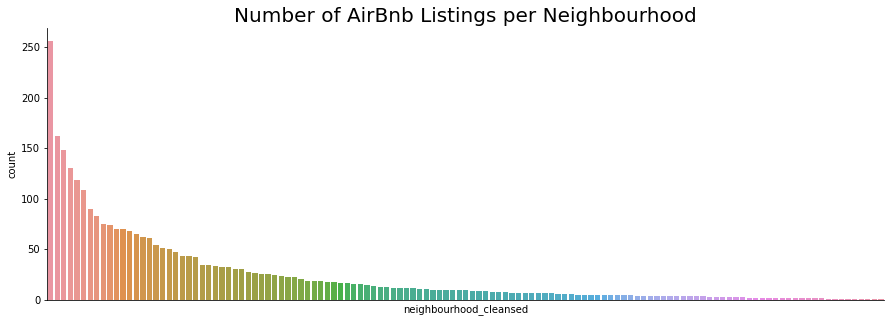

In [260]:
#visualize the number of listings in each neighbourhood in a barchart using seaborn:
fig, ax = plt.subplots(figsize = (15,5))

plot = sns.countplot(x='neighbourhood_cleansed', 
                     data=listings_df,  
                     order= listings_df.neighbourhood_cleansed.value_counts().index)

ax.set_xticks([]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Number of AirBnb Listings per Neighbourhood', fontsize = 20)

[]

Text(0.5, 1.0, 'Average Price of Neighbourhood Listings for Berlin')

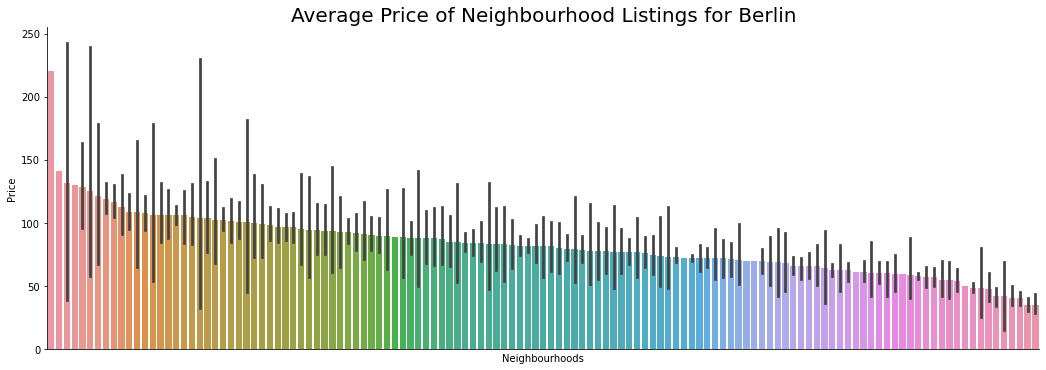

In [261]:
# Visualize avg price per night of listings within each neighbourhood &
# ordering by decending avg price and incl. std dev using seaborn :

plot = sns.catplot(x="neighbourhood_cleansed", 
                   y = "price", 
                   data = listings_df, 
                   height = 5, aspect = 3, 
                   kind="bar", order = neighbourhoods_detailed_avg_price.neighbourhood_cleansed)

plot.set_axis_labels("Neighbourhoods", "Price")
plot.ax.set_xticks([]);
plt.title('Average Price of Neighbourhood Listings for Berlin', fontsize = 20)

In [262]:
#Lots of neighbourhoods have a high std dev -->reason: buckets with very small sample size!:
#e.g. multiple neighbourhoods only have 1 Value - so Price here isn't a true average, indicated by missing std.

In [263]:
#To visualize only "true" averages we will drop neighbourhoods with <10 listings:
less_than_8 = listings_df.neighbourhood_cleansed.value_counts().loc[(listings_df.neighbourhood_cleansed.value_counts() < 8)]
neighbourhoods_detailed_avg_price = neighbourhoods_detailed_avg_price[~neighbourhoods_detailed_avg_price.neighbourhood_cleansed.isin(less_than_8.index)]

In [264]:
#Attach geo info from neighbourhoods_geo to allocate neighbourhood_cleansed on a map:
neighbourhoods_detailed_avg_price_geo = neighbourhoods_detailed_avg_price.merge(neighbourhoods_geo['geometry'],left_on=['neighbourhood_cleansed'],right_on=neighbourhoods_geo['neighbourhood'])
neighbourhoods_detailed_avg_price_geo = gpd.GeoDataFrame(neighbourhoods_detailed_avg_price_geo, geometry='geometry')

<AxesSubplot:>

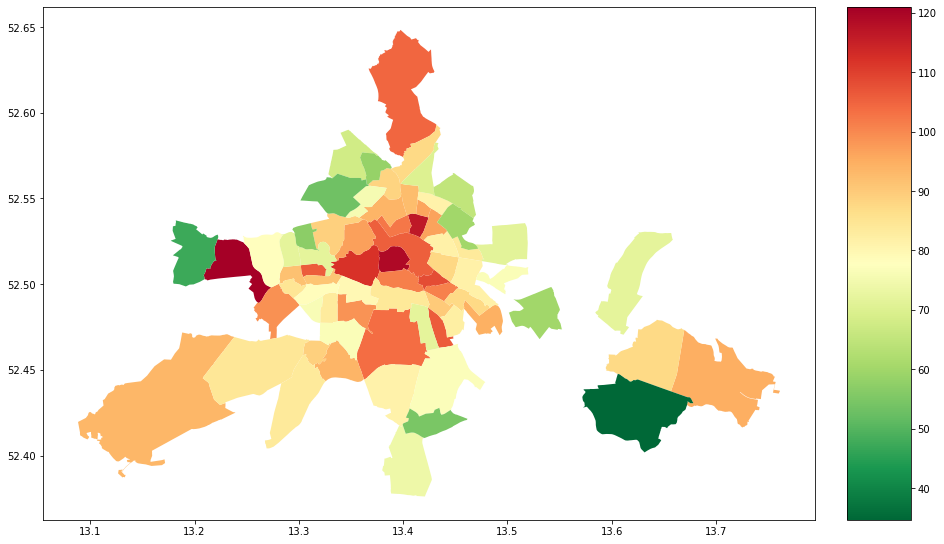

In [265]:
#Using geopandas to visualize above shown avg prices on a map:
fig, ax = plt.subplots(figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-3)
neighbourhoods_detailed_avg_price_geo.plot(column='price', legend = True, ax=ax, cax=cax, cmap='RdYlGn_r')

## Price Comparison on grouped neighbourhood level

In [266]:
#Create Abbriviations for the neighbourhood groups:
temp = listings_df.neighbourhood_group_cleansed.str.split(" ", expand=True)
temp = temp[0].str.split("-", expand=True)
listings_df['neighbourhood_group_cleansed_short'] = temp[0]
listings_df['neighbourhood_group_cleansed_short'].unique()

array(['Mitte', 'Pankow', 'Friedrichshain', 'Neukölln', 'Charlottenburg',
       'Tempelhof', 'Lichtenberg', 'Steglitz', 'Treptow', 'Reinickendorf',
       'Marzahn', 'Spandau'], dtype=object)

In [267]:
#check how many listings remain for each neighbouthood:
listings_df['neighbourhood_group_cleansed_short'].value_counts()

Mitte             747
Friedrichshain    579
Pankow            541
Charlottenburg    302
Neukölln          249
Tempelhof         238
Treptow           117
Steglitz           77
Lichtenberg        68
Reinickendorf      45
Spandau            39
Marzahn            27
Name: neighbourhood_group_cleansed_short, dtype: int64

In [268]:
# Get mean price per night of listings within each grouped neighbourhood:
neighbourhoods_avg_price = listings_df.groupby(by = ['neighbourhood_group_cleansed_short', 'neighbourhood_group_cleansed']).price.mean().sort_values(ascending=False).reset_index()

In [269]:
neighbourhoods_avg_price

,neighbourhood_group_cleansed_short,neighbourhood_group_cleansed,price
0,Mitte,Mitte,99.988822
1,Pankow,Pankow,93.605841
2,Steglitz,Steglitz - Zehlendorf,88.628571
3,Friedrichshain,Friedrichshain-Kreuzberg,88.477185
4,Tempelhof,Tempelhof - Schöneberg,88.001597
5,Charlottenburg,Charlottenburg-Wilm.,83.981093
6,Spandau,Spandau,83.717949
7,Neukölln,Neukölln,83.631647
8,Marzahn,Marzahn - Hellersdorf,82.925926
9,Treptow,Treptow - Köpenick,80.666667


In [270]:
#Setting colour palette for the 12 neigbourhood groups:
sns.set_palette(sns.color_palette('RdYlGn', 12))

Text(0.5, 1.0, 'Number of AirBnb Listings per grouped Neighbourhood')

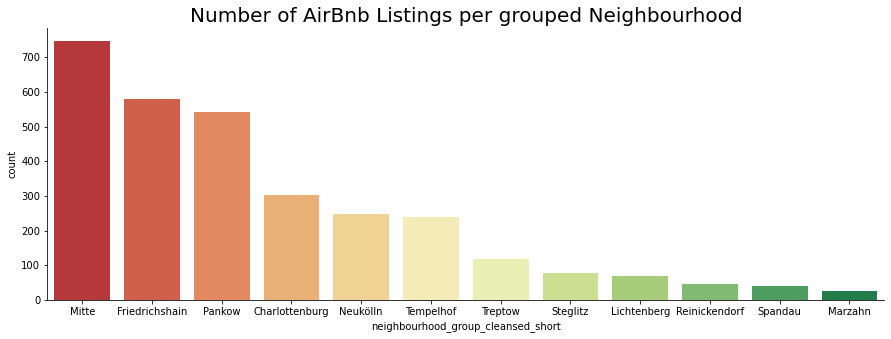

In [271]:
#visualize the number of listings in each neighbourhood in a barchart using seaborn:
fig, ax = plt.subplots(figsize = (15,5))

plot = sns.countplot(x='neighbourhood_group_cleansed_short', 
                     data=listings_df, 
                     order= listings_df.neighbourhood_group_cleansed_short.value_counts().index)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Number of AirBnb Listings per grouped Neighbourhood', fontsize = 20)

In [272]:
#taking a first statistical look at the pricings:
listings_df.price.describe()

count    3029.000000
mean       90.338858
std        53.348245
min        15.000000
25%        55.000000
50%        77.000000
75%       105.000000
max       390.000000
Name: price, dtype: float64

In [273]:
#check number of listings in each neighbourhood
listings_df.groupby('neighbourhood_group_cleansed_short').price.mean().sort_values()

neighbourhood_group_cleansed_short
Reinickendorf     69.441111
Lichtenberg       74.316176
Treptow           80.666667
Marzahn           82.925926
Neukölln          83.631647
Spandau           83.717949
Charlottenburg    83.981093
Tempelhof         88.001597
Friedrichshain    88.477185
Steglitz          88.628571
Pankow            93.605841
Mitte             99.988822
Name: price, dtype: float64

Text(0.5, 1.0, "Average Price of Listings in Berlin's Neighbourhoods")

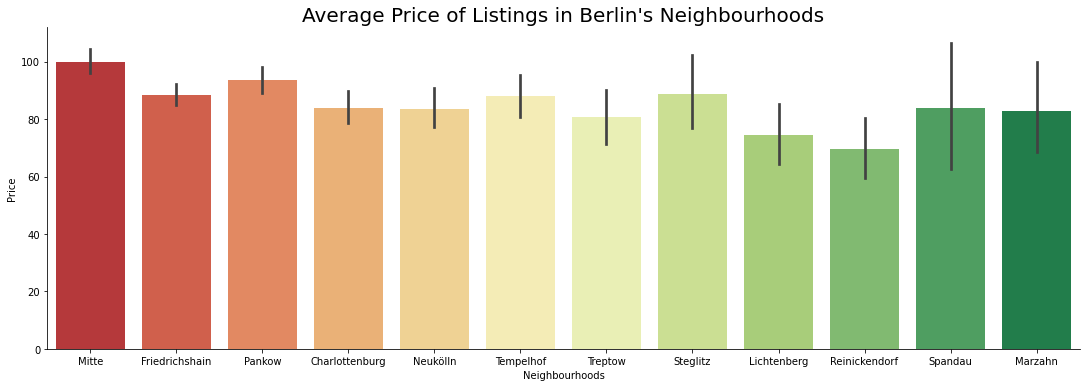

In [274]:
# Visualize avg price per night of listings within each groupneighbourhood &
# ordering by decending avg price incl std dev using seaborn :
plot = sns.catplot(x="neighbourhood_group_cleansed_short", y = "price", 
                   data = listings_df, 
                   height = 5, aspect = 3, 
                   kind="bar", 
                   order= listings_df.neighbourhood_group_cleansed_short.value_counts().index)

(plot.set_axis_labels("Neighbourhoods", "Price"))
plt.title('Average Price of Listings in Berlin\'s Neighbourhoods', fontsize = 20)

In [275]:
#Still a high std dev for some grouped neighbourhoods but significantly less than on detailed neighbourhood lvl 
# -->probably due to more samples / bucket

In [276]:
#Attach geo info from neighbourhoods_geo to allocate neighbourhood_group_cleansed_short on a map:
neighbourhoods_avg_price_gdf = neighbourhoods_avg_price.merge(neighbourhoods_geo['geometry'],left_on=['neighbourhood_group_cleansed'],right_on=neighbourhoods_geo['neighbourhood_group'])
neighbourhoods_avg_price_gdf = gpd.GeoDataFrame(neighbourhoods_avg_price_gdf, geometry='geometry')

In [277]:
#Use the dissolve function to combine MULTIPOLYGONS (describing the detailed neighbourhoods) to lvl of grouped neighbourhoods: 
neighbourhoods_avg_price_gdf = neighbourhoods_avg_price_gdf.dissolve(by ='neighbourhood_group_cleansed').reset_index()

In [278]:
#Attach a col carrying the center coordinat of each grouped neighbourhood: 
neighbourhoods_avg_price_gdf['coords'] = neighbourhoods_avg_price_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
neighbourhoods_avg_price_gdf['coords'] = [coords[0] for coords in neighbourhoods_avg_price_gdf['coords']]

0      Annotation(13.2702, 52.501, 'Charlottenburg')
1     Annotation(13.4283, 52.5039, 'Friedrichshain')
2        Annotation(13.5098, 52.5349, 'Lichtenberg')
3            Annotation(13.5788, 52.5211, 'Marzahn')
4               Annotation(13.366, 52.5329, 'Mitte')
5            Annotation(13.455, 52.4411, 'Neukölln')
6             Annotation(13.4403, 52.5972, 'Pankow')
7      Annotation(13.2913, 52.5957, 'Reinickendorf')
8            Annotation(13.1788, 52.5258, 'Spandau')
9           Annotation(13.2391, 52.4348, 'Steglitz')
10         Annotation(13.3808, 52.4412, 'Tempelhof')
11           Annotation(13.6112, 52.4296, 'Treptow')
dtype: object

<AxesSubplot:>

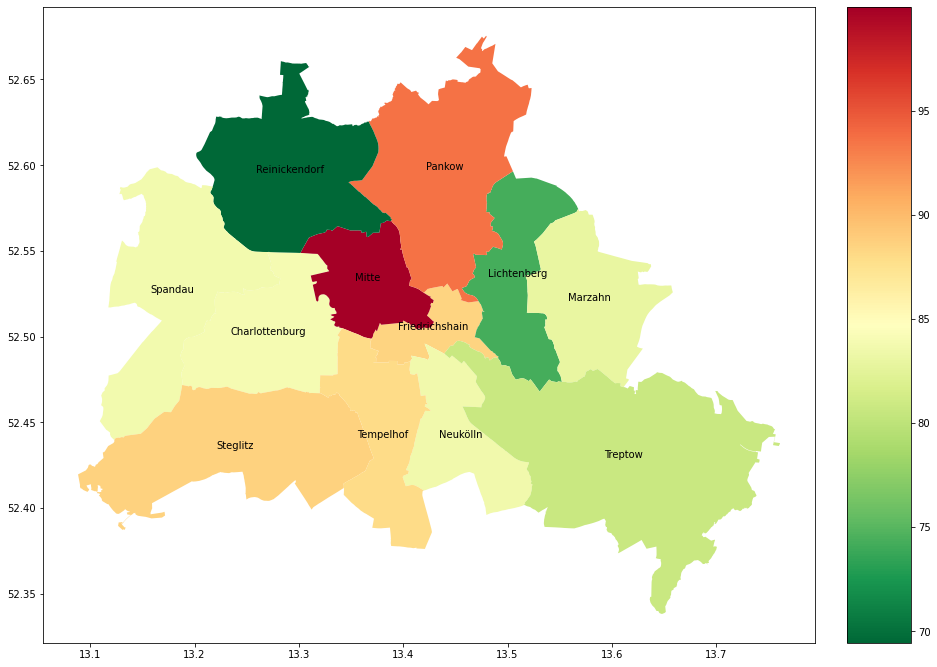

In [279]:
#Using geopandas to visualize above shown avg prices on a map:
fig, ax = plt.subplots(figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-3)
neighbourhoods_avg_price_gdf.apply(
    lambda x: ax.annotate(text=x.neighbourhood_group_cleansed_short, 
                          xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

neighbourhoods_avg_price_gdf.plot(column='price', legend = True, ax=ax, cax=cax, cmap='RdYlGn_r')

### For the further analysis we will stick with comparison by grouped neighbourhoods.

# 2. What's the occupancy rate of active airbnb listings in Berlin?

### We'll estimate the occupancy rate based on reviews: 

In [280]:
##We can only take listings into account the have at least 1 review. 
#Also we want the review_timespan to be at least 90 days:
print("{} listing's review-timespan is less than 90 days and will therefore be dropped.".format(
    (listings_df.review_timespan < 90).sum()))

listings_occupancy = listings_df.loc[(listings_df.review_timespan >= 90)]

468 listing's review-timespan is less than 90 days and will therefore be dropped.


In [281]:
#We only want to take listings into account where the host has been around for over 90 days.
print("{} listings have not been around for atleast 90 days and will therefore be dropped.".format(
    (listings_occupancy.host_4_Xdays < 90).sum()))

listings_occupancy = listings_occupancy.loc[(listings_occupancy.host_4_Xdays >= 90)]

0 listings have not been around for atleast 90 days and will therefore be dropped.


In [282]:
#Let's check if reviews_per_month was calculated similar to: 
# "reviews_per_month = number_of_reviews / review_timespan"
#to be sure we know what we are working with:
listings_occupancy['reviews_per_month_self'] = (listings_occupancy.number_of_reviews / 
                                                (listings_occupancy.review_timespan / 30.42))

(listings_occupancy.reviews_per_month - listings_occupancy['reviews_per_month_self']).describe()

count    2561.000000
mean       -0.195223
std         0.313347
min        -4.139401
25%        -0.199674
50%        -0.096651
75%        -0.044082
max         0.000617
dtype: float64

In [283]:
#Not the same but close. We will continue working with the given column reviews_per_month.

In [284]:
# We want to use minimum_nights for our estimation. 
#But before we do so, let's have a look at the values:

listings_occupancy.minimum_nights.describe()

count    2561.000000
mean       14.084733
std        49.448887
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max      1124.000000
Name: minimum_nights, dtype: float64

In [285]:
#How many listings are effected when flattening the attribute?:
(listings_occupancy.minimum_nights >30).sum()/listings_occupancy.shape[0]

0.09800859039437719

In [286]:
#Some listings have the minimum_nights set to values as high as 1124. Those outliers don't seem plausible. 
#Instead of dropping them we will overwrite those values with the average of minimum_nights <=7:
mean_of_upto_7_days = listings_occupancy.loc[(listings_occupancy.minimum_nights <=7),['minimum_nights']].mean()[0]
listings_occupancy.loc[(listings_occupancy.minimum_nights >7),['minimum_nights']] = mean_of_upto_7_days

In [287]:
# statistics on the price, reviews_per_month and minimum_nights columns:
listings_occupancy[['reviews_per_month', 'minimum_nights']].describe()

,reviews_per_month,minimum_nights
count,2561.000000,2561.000000
mean,1.430469,2.635226
std,1.505512,1.307356
min,0.020000,1.000000
25%,0.320000,2.000000
50%,0.880000,2.635226
75%,2.110000,3.000000
max,15.540000,7.000000


In [288]:
#Next, we'll multiply the reviews_per_month with the minimum_nights column indication how long a reviewer stayed at least.
#The result is a very conservative estimate of how many days per month the listings are occupied.

listings_occupancy['occ_per_month'] = (listings_occupancy.reviews_per_month * 
                                        listings_occupancy.minimum_nights)

listings_occupancy['occ_per_month'].describe()

count    2561.000000
mean        3.181359
std         3.307639
min         0.050000
25%         0.800000
50%         2.040000
75%         4.580000
max        37.320000
Name: occ_per_month, dtype: float64

In [289]:
print('The considered listings have an average stay of {:.2f} days.'.format(
    listings_occupancy['minimum_nights'].mean()))

The considered listings have an average stay of 2.64 days.


In [290]:
#Not the same but close. We will continue working with the given column reviews_per_month for now. 
#Now let's create subset to compare avg reviews_per_month and sort decending:
neighbourhoods_avg_occ = listings_occupancy.groupby(by = ['neighbourhood_group_cleansed_short',
                                                          'neighbourhood_group_cleansed']
                            ).occ_per_month.mean().sort_values(ascending=False).reset_index()

neighbourhoods_avg_occ

,neighbourhood_group_cleansed_short,neighbourhood_group_cleansed,occ_per_month
0,Mitte,Mitte,3.748975
1,Lichtenberg,Lichtenberg,3.437131
2,Friedrichshain,Friedrichshain-Kreuzberg,3.393780
3,Pankow,Pankow,3.256000
4,Neukölln,Neukölln,2.871703
5,Reinickendorf,Reinickendorf,2.780350
6,Tempelhof,Tempelhof - Schöneberg,2.697279
7,Marzahn,Marzahn - Hellersdorf,2.615197
8,Charlottenburg,Charlottenburg-Wilm.,2.605379
9,Steglitz,Steglitz - Zehlendorf,2.567630


Text(0.5, 1.0, 'Number of AirBnb Listings per grouped Neighbourhood')

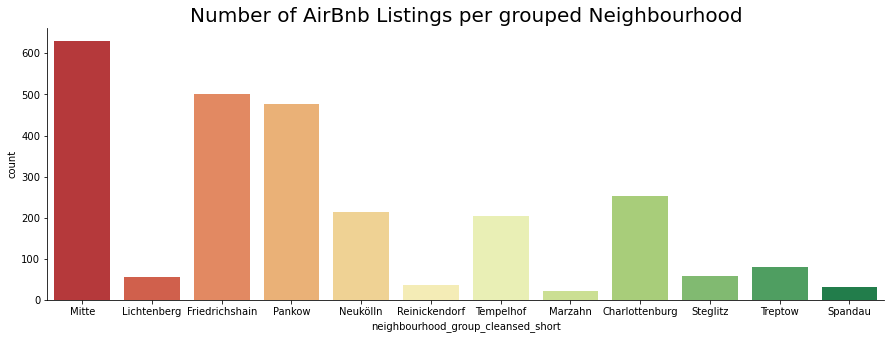

In [291]:
#visualize the number of listings in each neighbourhood in a barchart using seaborn:
sns.set_palette('RdYlGn',12)
fig, ax = plt.subplots(figsize = (15,5))

plot = sns.countplot(x='neighbourhood_group_cleansed_short', 
                     data=listings_occupancy, 
                     order = neighbourhoods_avg_occ.neighbourhood_group_cleansed_short)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Number of AirBnb Listings per grouped Neighbourhood', fontsize = 20)

In [292]:
#checking statistics on listings_occupancy:
listings_occupancy.groupby('neighbourhood_group_cleansed_short').occ_per_month.describe()[['count', 'mean', 'std', 'min','max']]

,count,mean,std,min,max
neighbourhood_group_cleansed_short,,,,,
Charlottenburg,252.0,2.605379,2.585771,0.079057,19.04
Friedrichshain,501.0,3.393780,3.692711,0.052705,37.32
Lichtenberg,56.0,3.437131,3.383767,0.210818,15.93
Marzahn,22.0,2.615197,2.142490,0.210000,7.95
Mitte,630.0,3.748975,3.790689,0.052705,26.64
Neukölln,213.0,2.871703,3.496990,0.050000,19.72
Pankow,477.0,3.256000,3.071005,0.070000,15.36
Reinickendorf,36.0,2.780350,1.803880,0.184466,6.30
Spandau,32.0,1.286406,1.572863,0.184466,7.50


In [293]:
#Attaach geo info from neighbourhoods_geo to allocate neighbourhood_group_cleansed_short on a map:
neighbourhoods_avg_occ_gdf = neighbourhoods_avg_occ.merge(
    neighbourhoods_geo['geometry'],
    left_on=['neighbourhood_group_cleansed'],
    right_on=neighbourhoods_geo['neighbourhood_group'])

neighbourhoods_avg_occ_gdf = gpd.GeoDataFrame(neighbourhoods_avg_occ_gdf, geometry='geometry')

In [294]:
#Use the dissolve function to combine MULTIPOLYGONS (describing the detailed neighbourhoods) to lvl of grouped neighbourhoods: 
neighbourhoods_avg_occ_gdf = neighbourhoods_avg_occ_gdf.dissolve(by ='neighbourhood_group_cleansed_short').reset_index()

In [295]:
#Attach a col carrying the center coordinat of each grouped neighbourhood: 
neighbourhoods_avg_occ_gdf['coords'] = neighbourhoods_avg_occ_gdf['geometry'].apply(
                                        lambda x: x.representative_point().coords[:])

neighbourhoods_avg_occ_gdf['coords'] = [coords[0] for coords in neighbourhoods_avg_occ_gdf['coords']]

0      Annotation(13.2702, 52.501, 'Charlottenburg')
1     Annotation(13.4283, 52.5039, 'Friedrichshain')
2        Annotation(13.5098, 52.5349, 'Lichtenberg')
3            Annotation(13.5788, 52.5211, 'Marzahn')
4               Annotation(13.366, 52.5329, 'Mitte')
5            Annotation(13.455, 52.4411, 'Neukölln')
6             Annotation(13.4403, 52.5972, 'Pankow')
7      Annotation(13.2913, 52.5957, 'Reinickendorf')
8            Annotation(13.1788, 52.5258, 'Spandau')
9           Annotation(13.2391, 52.4348, 'Steglitz')
10         Annotation(13.3808, 52.4412, 'Tempelhof')
11           Annotation(13.6112, 52.4296, 'Treptow')
dtype: object

<AxesSubplot:>

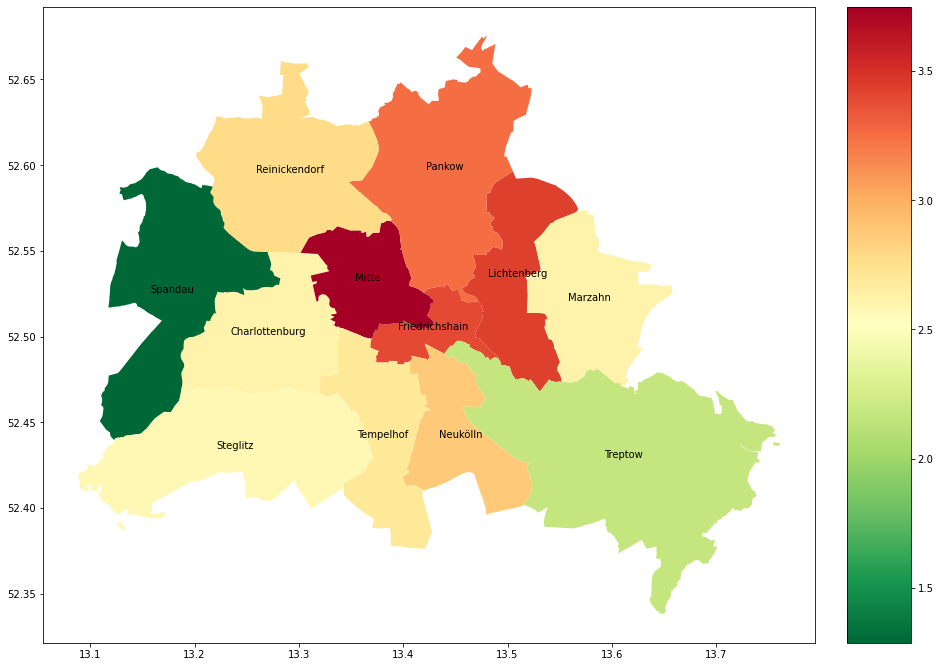

In [296]:
#Using geopandas to visualize above shown avg prices on a map:
fig, ax = plt.subplots(figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-3)
neighbourhoods_avg_occ_gdf.apply(lambda x: ax.annotate(text=x.neighbourhood_group_cleansed_short, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
neighbourhoods_avg_occ_gdf.plot(column='occ_per_month', legend = True, ax=ax, cax=cax, cmap='RdYlGn_r')

# 3. **What's the average revenue of active airbnb listings in Berlin?**

In [297]:
#create sub_df of listings_occupancy to work with:
listings_revenue = listings_occupancy 

In [298]:
#Calculate avg_rev_per_month column:
listings_revenue['avg_rev_per_month'] = listings_revenue.occ_per_month * listings_revenue.price 

In [299]:
#Calculate the average revenue and sort valued decending:
neighbourhoods_avg_rev = listings_revenue.groupby(
    by = ['neighbourhood_group_cleansed_short','neighbourhood_group_cleansed']
    ).avg_rev_per_month.mean().sort_values(ascending=False).reset_index()

In [300]:
#Merging neighbourhoods_avg_occ_gdf and neighbourhoods_avg_price:
neighbourhoods_avg_rev_gdf = neighbourhoods_avg_occ_gdf.merge(
    neighbourhoods_avg_price['price'], 
    left_on = 'neighbourhood_group_cleansed_short',
    right_on = neighbourhoods_avg_price['neighbourhood_group_cleansed_short'])


In [301]:
#Again, calculate the average revenue for the gdf:
neighbourhoods_avg_rev_gdf['avg_rev_per_month'] = neighbourhoods_avg_rev_gdf.occ_per_month * neighbourhoods_avg_rev_gdf.price

0      Annotation(13.2702, 52.501, 'Charlottenburg')
1     Annotation(13.4283, 52.5039, 'Friedrichshain')
2        Annotation(13.5098, 52.5349, 'Lichtenberg')
3            Annotation(13.5788, 52.5211, 'Marzahn')
4               Annotation(13.366, 52.5329, 'Mitte')
5            Annotation(13.455, 52.4411, 'Neukölln')
6             Annotation(13.4403, 52.5972, 'Pankow')
7      Annotation(13.2913, 52.5957, 'Reinickendorf')
8            Annotation(13.1788, 52.5258, 'Spandau')
9           Annotation(13.2391, 52.4348, 'Steglitz')
10         Annotation(13.3808, 52.4412, 'Tempelhof')
11           Annotation(13.6112, 52.4296, 'Treptow')
dtype: object

<AxesSubplot:>

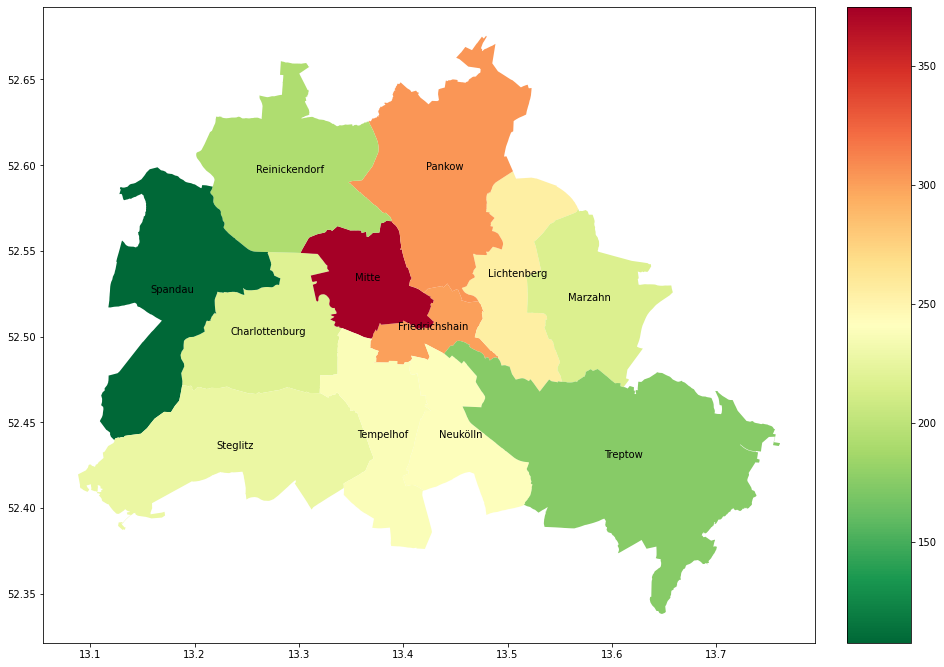

In [302]:
#Using geopandas to visualize above shown avg prices on a map:
fig, ax = plt.subplots(figsize = (20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-3)
neighbourhoods_avg_rev_gdf.apply(lambda x: ax.annotate(text=x.neighbourhood_group_cleansed_short, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
neighbourhoods_avg_rev_gdf.plot(column='avg_rev_per_month', legend = True, ax=ax, cax=cax, cmap='RdYlGn_r')

Text(0.5, 0.98, 'Overview: Average Price, Occupancy & Revenue')

Text(0.5, 1.0, 'Average Listing Price [in $]')

Text(0.5, 1.0, 'Average monthly Occupancy [in days]')

Text(0.5, 1.0, 'Average monthly Revenue [in $]')

<AxesSubplot:title={'center':'Average Listing Price [in $]'}>

<AxesSubplot:title={'center':'Average monthly Occupancy [in days]'}>

<AxesSubplot:title={'center':'Average monthly Revenue [in $]'}>

<AxesSubplot:xlabel='price', ylabel='neighbourhood_group_cleansed_short'>

<AxesSubplot:xlabel='occ_per_month', ylabel='neighbourhood_group_cleansed_short'>

<AxesSubplot:xlabel='avg_rev_per_month', ylabel='neighbourhood_group_cleansed_short'>

Text(153.0, 0.5, '')

Text(0.5, 114.00000000000011, 'Average Price [in $]')

Text(546.8823529411765, 0.5, '')

Text(0.5, 114.00000000000011, 'Average Occupancy [in days]')

Text(940.764705882353, 0.5, '')

Text(0.5, 114.00000000000011, 'Average Revenue [in $]')

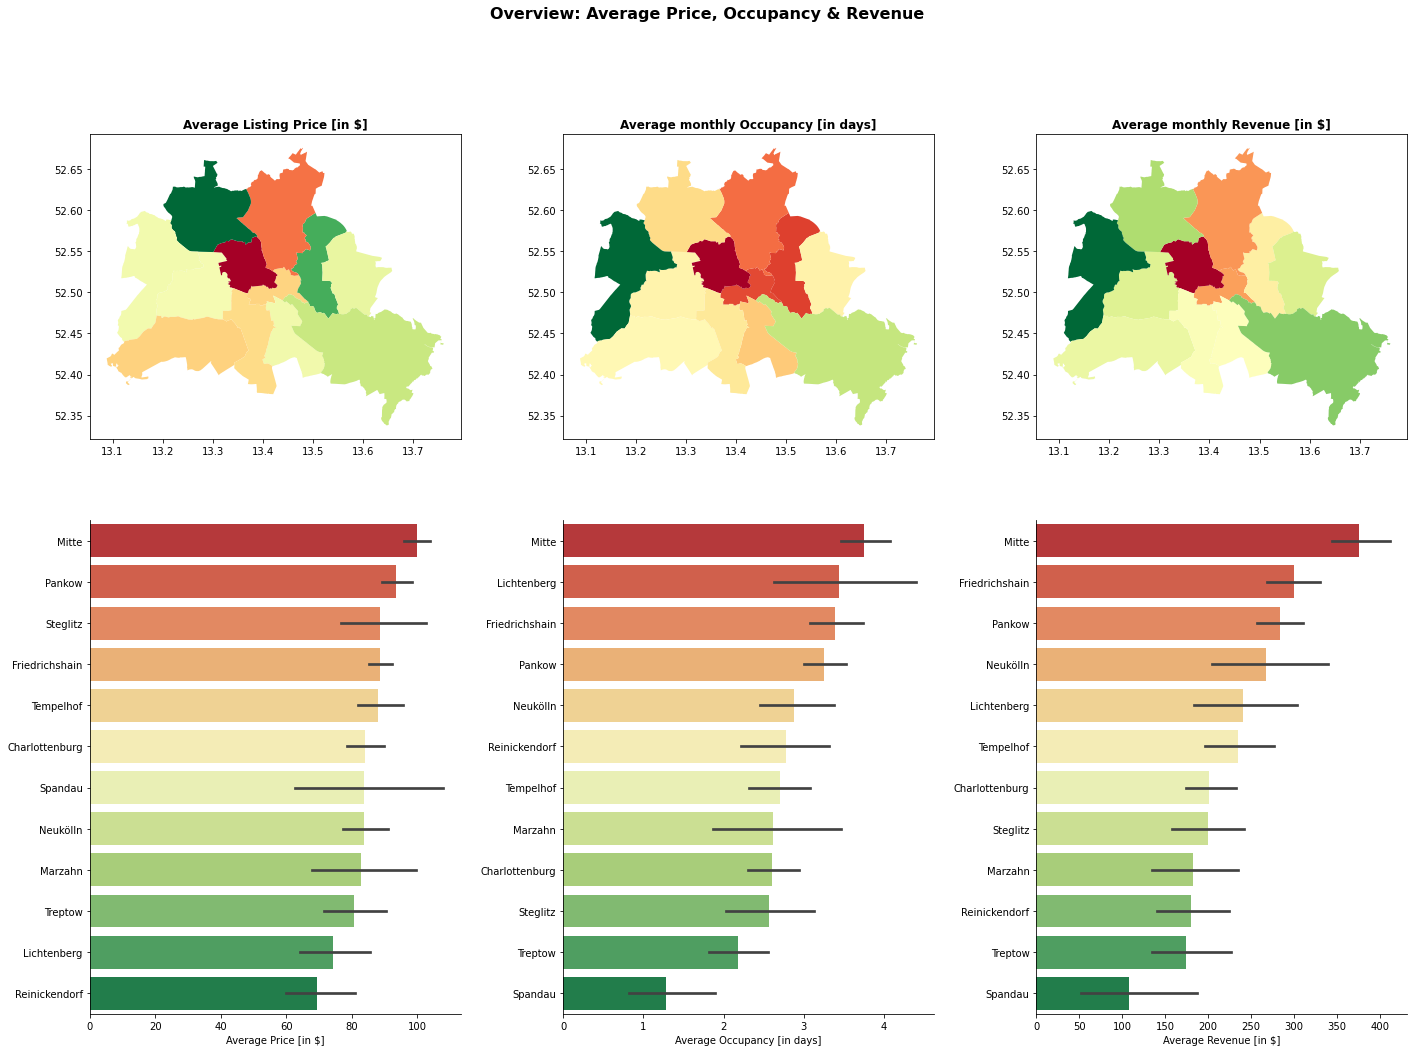

In [303]:
#Using geopandas to visualize above shown avg prices on a map:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize = (20,15))
fig.suptitle('Overview: Average Price, Occupancy & Revenue',fontsize = 16,fontweight = 'bold')

sns.set_palette('RdYlGn',12)

ax1.set_title("Average Listing Price [in $]",fontsize = 12,fontweight = 'bold')
ax2.set_title("Average monthly Occupancy [in days]",fontsize = 12,fontweight = 'bold')
ax3.set_title("Average monthly Revenue [in $]",fontsize = 12,fontweight = 'bold')

ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax6.spines["top"].set_visible(False)
ax6.spines["right"].set_visible(False)

neighbourhoods_avg_price_gdf.plot(column='price', ax=ax1, cmap='RdYlGn_r')
neighbourhoods_avg_occ_gdf.plot(column='occ_per_month', ax=ax2, cmap='RdYlGn_r')
neighbourhoods_avg_rev_gdf.plot(column='avg_rev_per_month', ax=ax3, cmap='RdYlGn_r')

sns.barplot(x="price", y = "neighbourhood_group_cleansed_short",orient ="h", data = listings_df, order = neighbourhoods_avg_price.neighbourhood_group_cleansed_short, ax=ax4)
sns.barplot(x="occ_per_month", y = "neighbourhood_group_cleansed_short",orient ="h", data = listings_occupancy, order = neighbourhoods_avg_occ.neighbourhood_group_cleansed_short, ax=ax5)
sns.barplot(x="avg_rev_per_month", y = "neighbourhood_group_cleansed_short",orient ="h", data = listings_revenue, order = neighbourhoods_avg_rev.neighbourhood_group_cleansed_short, ax=ax6)

ax4.set_ylabel('')    
ax4.set_xlabel('Average Price [in $]')
ax5.set_ylabel('')    
ax5.set_xlabel('Average Occupancy [in days]')
ax6.set_ylabel('')    
ax6.set_xlabel('Average Revenue [in $]')

plt.tight_layout(pad=2)

# 4. **Does being a Superhost effect the average revenue?**

In [304]:
#check number of superhost listings in the df:
listings_revenue.host_is_superhost.sum()

866

In [305]:
print("{:.2f}% of the considered listings are superhost listings.".format((listings_revenue.host_is_superhost.sum()/listings_revenue.shape[0])*100))

33.81% of the considered listings are superhost listings.


In [306]:
#Map the binary host_is_superhost column to more meaningful strings:
listings_revenue['Superhost?'] = listings_revenue.host_is_superhost.map({1 : 'Superhosts', 0 : 'Not_Superhosts'})

Text(0.5, 1.0, 'Superhost-Impact on the average monthly Revenue')

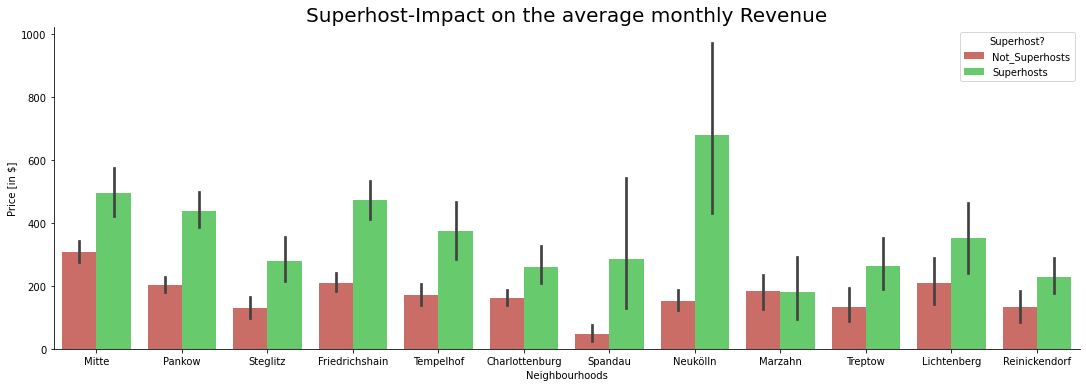

In [307]:
#visualize the data using seaborn:
sns.set_palette("hls", 3)
plot = sns.catplot(x="neighbourhood_group_cleansed_short", 
                   y = "avg_rev_per_month", 
                   data = listings_revenue, height = 5, aspect = 3, 
                   kind="bar", 
                   order = neighbourhoods_avg_price.neighbourhood_group_cleansed_short,
                   hue = 'Superhost?',
                   legend_out = False)

(plot.set_axis_labels("Neighbourhoods", "Price [in $]"))
plt.title('Superhost-Impact on the average monthly Revenue', fontsize = 20)

In [308]:
#checking the statistics for our listings_revenue data
#we can see that the std is very high for all neighbourhoods, 
#caused on the one hand by low sample sizes and on the other by
#outlier listings (max values) having significantly higher revenue that the average.
listings_revenue.groupby('neighbourhood_group_cleansed_short').avg_rev_per_month.describe()[['count', 'mean', 'std', 'min','max']]

,count,mean,std,min,max
neighbourhood_group_cleansed_short,,,,,
Charlottenburg,252.0,201.070921,238.738477,3.557555,2551.36
Friedrichshain,501.0,299.433323,347.226210,2.951453,2666.40
Lichtenberg,56.0,240.667120,235.798365,10.540905,1035.45
Marzahn,22.0,182.279188,125.656057,30.832146,548.55
Mitte,630.0,375.716630,438.122973,1.317613,3225.42
Neukölln,213.0,267.124132,521.083113,2.580000,4126.14
Pankow,477.0,283.563685,293.200923,4.950000,1957.30
Reinickendorf,36.0,180.206501,128.934249,4.980577,616.64
Spandau,32.0,107.528653,199.044179,7.378633,1087.50


In [309]:
# We can see that being a Superhost has a positive impact on revenue. 
print("On average being a Superhost increases revenue by {:.0f}$ in Berlin.".format(
    (listings_revenue.loc[listings_revenue.host_is_superhost == 1,].avg_rev_per_month.mean() - 
     listings_revenue.loc[listings_revenue.host_is_superhost == 0,].avg_rev_per_month.mean()).sum()))

On average being a Superhost increases revenue by 217$ in Berlin.


In [310]:
#checking the avg_rev_per_month_Superhosts for each neighbourhood:
avg_rev_per_month_Superhosts = listings_revenue.loc[listings_revenue.host_is_superhost == 1,].groupby('neighbourhood_group_cleansed').avg_rev_per_month.mean()
avg_rev_per_month_Superhosts = avg_rev_per_month_Superhosts.reset_index().sort_values('neighbourhood_group_cleansed')
avg_rev_per_month_Superhosts

,neighbourhood_group_cleansed,avg_rev_per_month
0,Charlottenburg-Wilm.,261.386919
1,Friedrichshain-Kreuzberg,471.573209
2,Lichtenberg,352.093807
3,Marzahn - Hellersdorf,178.960238
4,Mitte,495.851020
5,Neukölln,680.634205
6,Pankow,439.521948
7,Reinickendorf,227.009348
8,Spandau,284.732500
9,Steglitz - Zehlendorf,280.384571


# 5. **How does this compare to the average revenue from normal rent in the neighbourhoods?**

##### To answer this question we will use some data from from the web: 
We will use a combination of: <br>
[statistic_mietwohnung_fanzielle-belastung-in-berlin-2019](https://de.statista.com/themen/1605/wohnimmobilien-in-berlin/) for the average rent paid<br>
[Berliner Betriebskostenübersicht 2019](https://www.berliner-mieterverein.de/magazin/online/mm0719/berliner-betriebskostenuebersicht-2019-waermekosten-gesunken-kalte-betriebskosten-gestiegen-071921.htm#:~:text=2%2C56%20Euro%20pro%20Quadratmeter,Durchschnittsmieter%20jeden%20Monat%20an%20Betriebskosten.&text=Auff%C3%A4llig%20ist%2C%20dass%20die%20Kosten,niedriger%20als%20vor%20zwei%20Jahren.) for the average utility costs per qm in Berlin<br>
[Informationen zu den Immobilienpreisen in Berlin 2019](https://web.mcmakler.de/immobilienpreise/berlin?address=&center=13.657244983654437%2C52.35353625911344&marker=&tp_channel=DE_MCM_AFF_LG_WHGBOERSE&utm_campaign=wohnungsboerse&utm_content=preisatlas&utm_medium=affiliate&utm_source=wohnungsboerse&zoom=12) for the average rent per qm in Berlin

For Eur to USD conversion we will use the ratio $\frac{EUR}{USD} = \frac{1}{1.18}$ (as of Nov 19 2020).


In [311]:
#loading statistics:
normal_rent_df = pd.read_csv('Berlin_Rent_and_Utilitiy.csv', sep=";")
normal_rent_df = normal_rent_df.sort_values('neighbourhood_grouped').reset_index(drop= True)

In [312]:
#calculating the normal_net_cold_rent to represent the revenue for a landlord:
normal_rent_df['normal_net_cold_rent'] = (normal_rent_df.Rent_per_month - 
                                       (normal_rent_df.Rent_per_month * 
                                        (normal_rent_df.Berlin_avg_utility_cost_per_qm/normal_rent_df.Berlin_avg_rent_per_qm)))*1.18
normal_rent_df

,neighbourhood_grouped,Rent_per_month,Berlin_avg_rent_per_qm,Berlin_avg_utility_cost_per_qm,normal_net_cold_rent
0,Charlottenburg-Wilm.,793,9.16,2.56,674.223144
1,Friedrichshain-Kreuzberg,850,9.16,2.56,722.685590
2,Lichtenberg,611,9.16,2.56,519.483406
3,Marzahn - Hellersdorf,498,9.16,2.56,423.408734
4,Mitte,873,9.16,2.56,742.240611
5,Neukölln,640,9.16,2.56,544.139738
6,Pankow,713,9.16,2.56,606.205677
7,Reinickendorf,600,9.16,2.56,510.131004
8,Spandau,560,9.16,2.56,476.122271
9,Steglitz - Zehlendorf,700,9.16,2.56,595.152838


In [313]:
#merging normal_rent_df with the Airbnb neighbourhoods_avg_rev_gdf:
compare_avg_rev = neighbourhoods_avg_rev_gdf.merge(
    normal_rent_df['normal_net_cold_rent'] , 
    left_on='neighbourhood_group_cleansed', 
    right_on=normal_rent_df['neighbourhood_grouped'])

compare_avg_rev['avg_rev_per_month_Superhosts'] = avg_rev_per_month_Superhosts.avg_rev_per_month

In [314]:
#Calculate the mean for the 3 possibilities we checked out:
compare_avg_rev[['avg_rev_per_month', 'avg_rev_per_month_Superhosts','normal_net_cold_rent']].mean()

avg_rev_per_month               237.699196
avg_rev_per_month_Superhosts    359.266246
normal_net_cold_rent            579.069541
dtype: float64

In [315]:
#Preparing data to plot using seaborn:
compare_avg_rev.columns = ['Neighbourhoods_Grouped', 'geometry',
       'neighbourhood_group_cleansed', 'occ_per_month', 'coords', 'price',
       'AirBnb Listings', 'Long Term Lease',
       'AirBnb Superhost Listings']

In [316]:
#Preparing data to plot using seaborn:
compare_avg_rev_plot = pd.melt(compare_avg_rev[['Neighbourhoods_Grouped',
                                        'AirBnb Listings', 'Long Term Lease',
                                       'AirBnb Superhost Listings']], 
                           id_vars='Neighbourhoods_Grouped', 
                           var_name='Revenue_Options', value_name='monthly avg Revenue [in $]')

Text(0.5, 1.0, "Neighbourhood's average Revenue Comparison \n (assuming every guest leaves a review)")

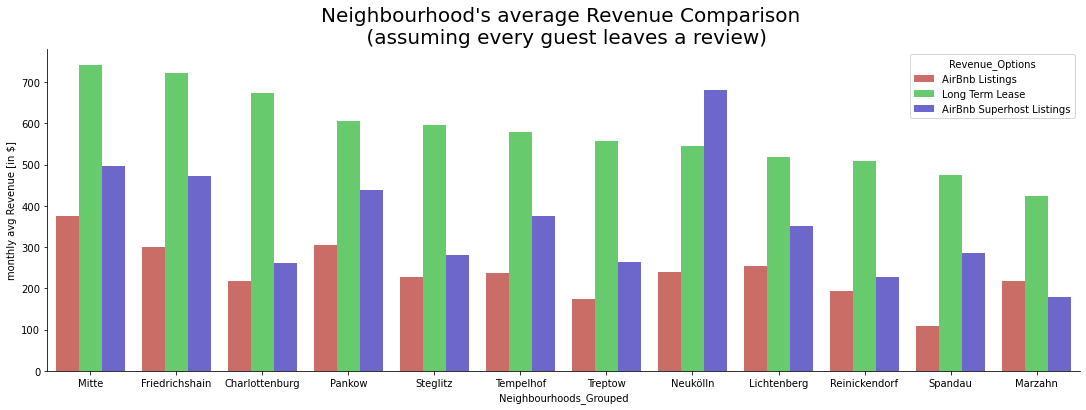

In [317]:
#Plotting the average revenues:
sns.set_palette("hls", 3)
sns.catplot(x='Neighbourhoods_Grouped', 
            y='monthly avg Revenue [in $]', 
            hue='Revenue_Options', 
            data=compare_avg_rev_plot, 
            kind='bar',
            height = 5, 
            aspect = 3,
            legend_out = False,
            order = compare_avg_rev.sort_values(by = 'Long Term Lease', ascending=False).Neighbourhoods_Grouped)

plt.title('Neighbourhood\'s average Revenue Comparison \n (assuming every guest leaves a review)', fontsize = 20)

In [318]:
#Let's assume only every second guest leaves a review. 
#The estimated occupancy rate would double, and so would the revenue for Airbnb listings:

double_avg_rev = compare_avg_rev
double_avg_rev['AirBnb Listings'] = double_avg_rev['AirBnb Listings'] *2
double_avg_rev['AirBnb Superhost Listings'] = double_avg_rev['AirBnb Superhost Listings'] *2

In [319]:
#Preparing data to plot using seaborn:
double_avg_rev_plot = pd.melt(
                            compare_avg_rev[['Neighbourhoods_Grouped',
                                             'AirBnb Listings', 
                                             'Long Term Lease',
                                             'AirBnb Superhost Listings']], 
                           id_vars='Neighbourhoods_Grouped', 
                           var_name='Revenue_Options', value_name='monthly avg Revenue [in $]')

Text(0.5, 1.0, "Neighbourhood's average Revenue \n (assuming half the guests leave a review)")

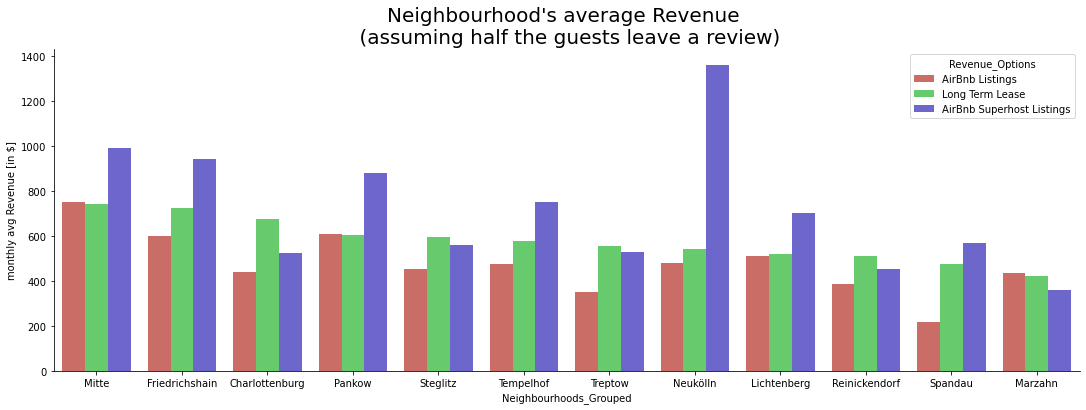

In [320]:
#Plotting the average revenues:
sns.set_palette("hls", 3)
sns.catplot(x='Neighbourhoods_Grouped', 
            y='monthly avg Revenue [in $]', 
            hue='Revenue_Options', 
            data=double_avg_rev_plot, 
            kind='bar',
            height = 5, 
            aspect = 3,
            legend_out = False,
            order = compare_avg_rev.sort_values(by = 'Long Term Lease', ascending=False).Neighbourhoods_Grouped)

plt.title('Neighbourhood\'s average Revenue \n (assuming half the guests leave a review)', fontsize = 20)